## 🎬 IMDB Movie Review Sentiment Dataset

### 🧾 Overview

The **IMDB Movie Review Dataset** is a widely used benchmark in Natural Language Processing (NLP) for **binary sentiment classification** — determining whether a movie review expresses a **positive** or **negative** opinion.

Each sample in the dataset is a single movie review written by a user on the [Internet Movie Database (IMDB)](https://www.imdb.com/), labeled as:

- **Positive (1):** The review reflects enjoyment or approval of the movie.
- **Negative (0):** The review expresses dislike or criticism of the movie.

The dataset contains:
- **25,000** labeled training reviews  
- **25,000** labeled test reviews  
All text data is preprocessed, and each review is already tokenized into words or indices (depending on the version you load).

---

### 📦 Dataset Source

This dataset is included in several libraries:

- **Keras / TensorFlow:**  
  ```python
  from tensorflow.keras.datasets import imdb
  (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)

In [2]:

# If needed:
# %pip install datasets --quiet

import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split

def load_imdb_via_hf(subset_train=20000, subset_test=5000, seed=7):
    """Load IMDB via Hugging Face datasets, returning raw text and labels.
    Subsample to keep runtime manageable.
    """
    try:
        from datasets import load_dataset
        ds = load_dataset("imdb")
        # Convert to pandas for easier subsampling
        train_df = pd.DataFrame({'text': ds['train']['text'], 'label': ds['train']['label']})
        test_df  = pd.DataFrame({'text': ds['test']['text'],  'label': ds['test']['label']})
        # Subsample
        train_df = train_df.sample(n=min(subset_train, len(train_df)), random_state=seed).reset_index(drop=True)
        test_df  = test_df.sample(n=min(subset_test,  len(test_df)),  random_state=seed).reset_index(drop=True)
        return train_df['text'].tolist(), train_df['label'].to_numpy(), test_df['text'].tolist(), test_df['label'].to_numpy()
    except Exception as e:
        print("HF datasets not available or failed:", e)
        return None

def load_imdb_via_keras(subset_train=20000, subset_test=5000, seed=7):
    """Fallback loader using Keras integer-encoded IMDB; returns decoded text strings if possible."""
    try:
        # %pip install tensorflow --quiet
        from tensorflow.keras.datasets import imdb
        from tensorflow.keras.preprocessing.sequence import pad_sequences
        from tensorflow.keras.datasets.imdb import get_word_index

        num_words = 50000
        (X_tr_i, y_tr), (X_te_i, y_te) = imdb.load_data(num_words=num_words)
        # Pad and decode into crude space-joined tokens
        word_index = get_word_index()
        index_word = {v+3: k for k,v in word_index.items()}
        index_word[0] = "<pad>"; index_word[1] = "<start>"; index_word[2] = "<unk>"; index_word[3] = "<unused>"
        def decode(seq):
            return " ".join(index_word.get(i, "<unk>") for i in seq)

        # Subsample
        rng = np.random.default_rng(seed)
        tr_idx = rng.choice(len(X_tr_i), size=min(subset_train, len(X_tr_i)), replace=False)
        te_idx = rng.choice(len(X_te_i), size=min(subset_test,  len(X_te_i)), replace=False)
        X_tr_txt = [decode(X_tr_i[i]) for i in tr_idx]
        X_te_txt = [decode(X_te_i[i]) for i in te_idx]
        y_tr_s = y_tr[tr_idx]; y_te_s = y_te[te_idx]
        return X_tr_txt, y_tr_s, X_te_txt, y_te_s
    except Exception as e:
        print("Keras IMDB not available or failed:", e)
        return None

# Try HF first, then Keras fallback
data = load_imdb_via_hf(subset_train=20000, subset_test=5000, seed=7)
if data is None:
    data = load_imdb_via_keras(subset_train=20000, subset_test=5000, seed=7)

if data is None:
    raise RuntimeError("Could not load IMDB via Hugging Face or Keras. Install one of them and retry.")

X_train_text, y_train, X_test_text, y_test = data
len(X_train_text), len(X_test_text), np.bincount(y_train), np.bincount(y_test)


(20000, 5000, array([ 9995, 10005]), array([2426, 2574]))

In [3]:
print(X_train_text[0][:100])

Not a movie for everyone, but this movie is in my top 10. I am a lover of black comedy. With a cast 


In [4]:
print(np.unique(y_train))

[0 1]


In [5]:
# Get the unique values and their counts
unique_values, counts = np.unique(y_test, return_counts=True)

# The number of unique values is simply the length of the unique_values array
num_unique_values = len(y_test)

print(f"Unique values: {y_test}")
print(f"Counts of unique values: {counts}")
print(f"Number of unique values: {num_unique_values}")

Unique values: [1 0 1 ... 0 0 1]
Counts of unique values: [2426 2574]
Number of unique values: 5000


In [6]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=50000,
    ngram_range=(1,2),
    min_df=2
)




### From‑Scratch Linear SVM on TruncatedSVD Features

Our NumPy‑only `LinearSVM` expects dense features. We’ll reuse the SVD‑reduced dense representation (200‑D) and train the from‑scratch model.



### 📚 Math for this section — TF‑IDF → SVD (LSA) → Linear SVM

**TF‑IDF weighting** for term \(t\) in document \(d\):
$
\mathrm{tf\!-\!idf}(t,d) = \mathrm{tf}(t,d)\cdot \underbrace{\log\frac{N}{\mathrm{df}(t)+1}}_{\mathrm{idf}(t)},
$
where $(\mathrm{tf}(t,d)$) is term frequency, $(\mathrm{df}(t)$) is document frequency, and \(N\) is #docs.

**Truncated SVD (LSA)** on sparse document–term matrix $(X) (size (N\times V$)):
$
X \approx U_k \Sigma_k V_k^\top,\quad \text{project } \mathbf{z}=\mathbf{x}V_k \in \mathbb{R}^k.
$

**Standardization** per feature $(j): (\tilde{z}_j = (z_j-\mu_j)/\sigma_j)$.

**Linear SVM hinge objective (binary)** with $(y_i'\in\{-1,+1\}$):

$$
\min_{\mathbf{w},b}\; \tfrac{1}{2}\lVert \mathbf{w}\rVert^2 + C\sum_i \max(0,\,1 - y_i'(\mathbf{w}^\top\mathbf{x}_i+b)).
$$

**Subgradient updates** (per sample) with margin $(m_i=y_i'(\mathbf{w}^\top\mathbf{x}_i+b)$):
$
\begin{aligned}
m_i \ge 1 &:&& \mathbf{w}\leftarrow \mathbf{w}-\eta\,\mathbf{w} \\
m_i < 1   &:&& \mathbf{w}\leftarrow \mathbf{w}-\eta\,(\mathbf{w}-C\,y_i'\mathbf{x}_i),\;\; b\leftarrow b+\eta\,C\,y_i'.
\end{aligned}
$

**Linear decision function:**
$s =  \mathbf{w}^\top\mathbf{x}_i+b$



Epoch 01/10  hinge+L2 loss: 24285.416
Epoch 02/10  hinge+L2 loss: 24943.401
Epoch 03/10  hinge+L2 loss: 24044.983
Epoch 04/10  hinge+L2 loss: 21810.714
Epoch 03/10  hinge+L2 loss: 24044.983
Epoch 04/10  hinge+L2 loss: 21810.714
Epoch 05/10  hinge+L2 loss: 25478.787
Epoch 06/10  hinge+L2 loss: 24423.969
Early stopping.
From-scratch Linear SVM — IMDB (SVD-200)
Train accuracy: 0.57175
              precision    recall  f1-score   support

         neg      0.574     0.558     0.566      9995
         pos      0.570     0.586     0.578     10005

    accuracy                          0.572     20000
   macro avg      0.572     0.572     0.572     20000
weighted avg      0.572     0.572     0.572     20000

Epoch 05/10  hinge+L2 loss: 25478.787
Epoch 06/10  hinge+L2 loss: 24423.969
Early stopping.
From-scratch Linear SVM — IMDB (SVD-200)
Train accuracy: 0.57175
              precision    recall  f1-score   support

         neg      0.574     0.558     0.566      9995
         pos      0.57

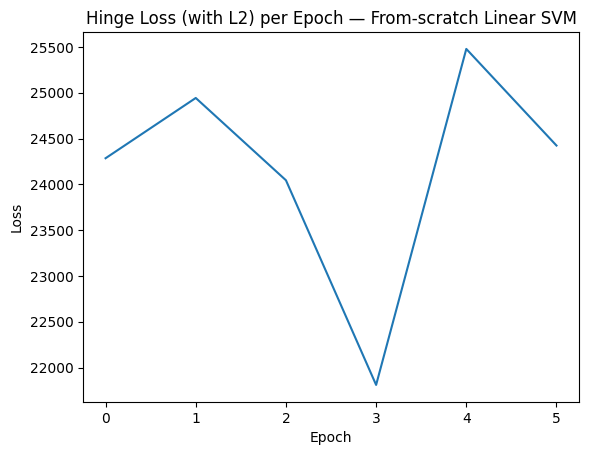

Epoch 01/10  hinge+L2 loss: 19337.613
Epoch 02/10  hinge+L2 loss: 19942.585
Epoch 03/10  hinge+L2 loss: 21058.122
Early stopping.
From-scratch Linear SVM — IMDB (SVD-200)
Train accuracy: 0.5677
              precision    recall  f1-score   support

         neg      0.581     0.483     0.528      9995
         pos      0.558     0.652     0.601     10005

    accuracy                          0.568     20000
   macro avg      0.570     0.568     0.565     20000
weighted avg      0.570     0.568     0.565     20000

Epoch 03/10  hinge+L2 loss: 21058.122
Early stopping.
From-scratch Linear SVM — IMDB (SVD-200)
Train accuracy: 0.5677
              precision    recall  f1-score   support

         neg      0.581     0.483     0.528      9995
         pos      0.558     0.652     0.601     10005

    accuracy                          0.568     20000
   macro avg      0.570     0.568     0.565     20000
weighted avg      0.570     0.568     0.565     20000



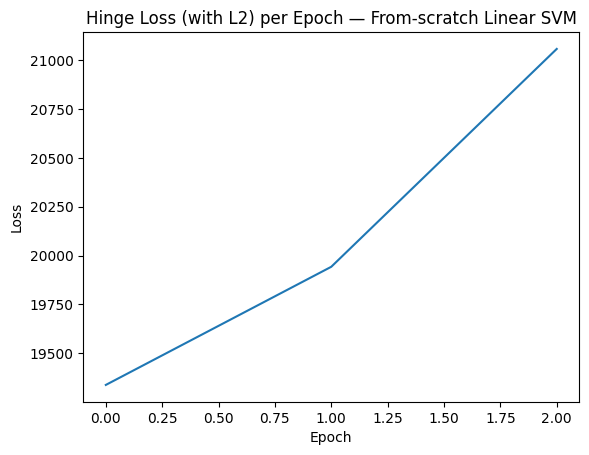

Epoch 01/10  hinge+L2 loss: 14049.953
Epoch 02/10  hinge+L2 loss: 14290.668
Epoch 03/10  hinge+L2 loss: 14113.882
Early stopping.
From-scratch Linear SVM — IMDB (SVD-200)
Train accuracy: 0.698
              precision    recall  f1-score   support

         neg      0.698     0.698     0.698      9995
         pos      0.698     0.698     0.698     10005

    accuracy                          0.698     20000
   macro avg      0.698     0.698     0.698     20000
weighted avg      0.698     0.698     0.698     20000

Epoch 03/10  hinge+L2 loss: 14113.882
Early stopping.
From-scratch Linear SVM — IMDB (SVD-200)
Train accuracy: 0.698
              precision    recall  f1-score   support

         neg      0.698     0.698     0.698      9995
         pos      0.698     0.698     0.698     10005

    accuracy                          0.698     20000
   macro avg      0.698     0.698     0.698     20000
weighted avg      0.698     0.698     0.698     20000



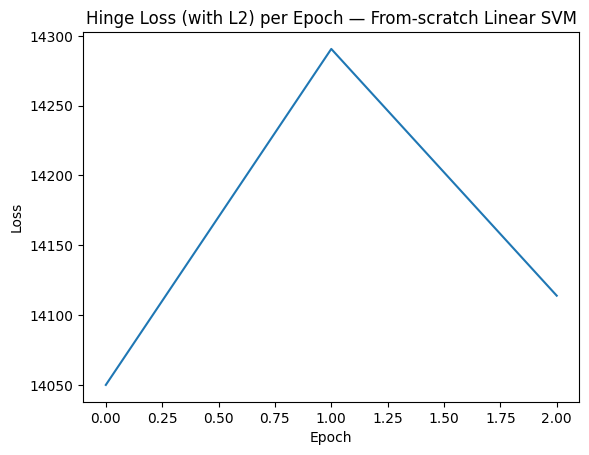

Epoch 01/10  hinge+L2 loss: 12010.687
Epoch 02/10  hinge+L2 loss: 12030.612
Epoch 03/10  hinge+L2 loss: 12070.400
Early stopping.
From-scratch Linear SVM — IMDB (SVD-200)
Train accuracy: 0.82885
              precision    recall  f1-score   support

         neg      0.850     0.798     0.823      9995
         pos      0.810     0.860     0.834     10005

    accuracy                          0.829     20000
   macro avg      0.830     0.829     0.829     20000
weighted avg      0.830     0.829     0.829     20000

Epoch 03/10  hinge+L2 loss: 12070.400
Early stopping.
From-scratch Linear SVM — IMDB (SVD-200)
Train accuracy: 0.82885
              precision    recall  f1-score   support

         neg      0.850     0.798     0.823      9995
         pos      0.810     0.860     0.834     10005

    accuracy                          0.829     20000
   macro avg      0.830     0.829     0.829     20000
weighted avg      0.830     0.829     0.829     20000



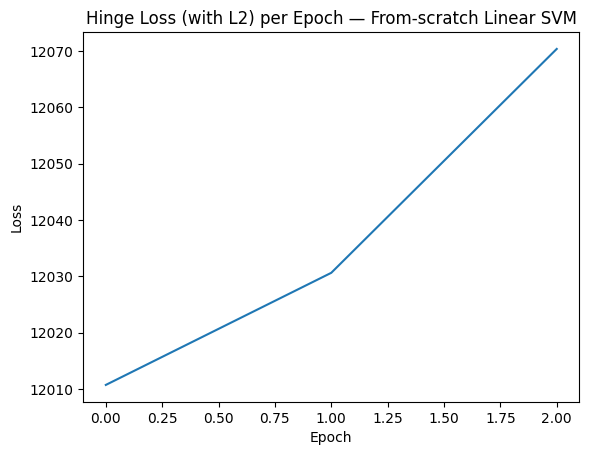

In [8]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# ---------------- From-scratch Linear SVM ----------------
class LinearSVMScratch:
    def __init__(self, C=1.0, lr=0.1, n_epochs=10, lr_decay=0.0, shuffle=True, random_state=7, early_stopping=False, es_patience=3):
        self.C = float(C)
        self.lr = float(lr)
        self.n_epochs = int(n_epochs)
        self.lr_decay = float(lr_decay)
        self.shuffle = bool(shuffle)
        self.random_state = int(random_state)
        self.early_stopping = bool(early_stopping)
        self.es_patience = int(es_patience)
        self.w_ = None
        self.b_ = 0.0
        self.loss_curve_ = []

    @staticmethod
    def _to_pm1(y):
        y = np.asarray(y).astype(int)
        if set(np.unique(y)) == {0,1}:
            return np.where(y==1, 1, -1)
        elif set(np.unique(y)) == {-1,1}:
            return y
        else:
            raise ValueError("Labels must be in {0,1} or {-1,+1}.")

    def _hinge_loss(self, X, ypm1):
        # ------------------------------------------------
        # TODO Refer to the Linear SVM hinge objective defined in the cell above (Exercise 1)
        # ------------------------------------------------
        margins = 1.0 - ypm1 * (X @ self.w_ + self.b_)
        return 0.5*np.dot(self.w_, self.w_) + self.C * np.maximum(0.0, margins).sum()
        # ----------------------------
        # Implementation Ends Here
        # ----------------------------

    def fit(self, X, y):
        rng = np.random.default_rng(self.random_state)
        X = np.asarray(X, dtype=float)
        ypm1 = self._to_pm1(y)
        n, d = X.shape
        self.w_ = np.zeros(d, dtype=float)
        self.b_ = 0.0
        idx = np.arange(n)
        best = np.inf
        bad = 0

        for epoch in range(self.n_epochs):
            if self.shuffle:
                rng.shuffle(idx)
            eta = self.lr / (1.0 + self.lr_decay * epoch)

            for i in idx:
                xi = X[i]; yi = ypm1[i]
                # ------------------------------------------------
                # TODO Refer to the Subgradient updates (per sample) with margin equation in the cell above (Exercise 2)
                # ------------------------------------------------
                margin = yi * (np.dot(self.w_, xi) + self.b_)
                # ----------------------------
                # Implementation Ends Here
                # ----------------------------
                if margin >= 1.0:
                    self.w_ -= eta * self.w_
                else:
                    self.w_ -= eta * (self.w_ - self.C * yi * xi)
                    self.b_ += eta * self.C * yi

            loss = self._hinge_loss(X, ypm1)
            self.loss_curve_.append(float(loss))
            print(f"Epoch {epoch+1:02d}/{self.n_epochs}  hinge+L2 loss: {loss:.3f}")

            if self.early_stopping:
                if loss < best - 1e-4:
                    best = loss; bad = 0
                else:
                    bad += 1
                    if bad >= self.es_patience:
                        print("Early stopping.")
                        break

        return self

    def decision_function(self, X):
        # ------------------------------------------------
        # TODO Refer to the linear decision function equation in the cell above (Exercise 3)
        # ------------------------------------------------
        return X @ self.w_ + self.b_
        # ----------------------------
        # Implementation Ends Here
        # ----------------------------

    def predict(self, X):
        # ------------------------------------------------
        # TODO We want to utilize the decision_function we defined in LinearSVMScratch. (Exercise 4)
        # ------------------------------------------------
        s = self.decision_function(X)
        # ----------------------------
        # Implementation Ends Here
        # ----------------------------
        return (s >= 0.0).astype(int)

# ---------------- Pipeline: TF-IDF -> SVD(200) -> Scaler ----------------
vectorizer = TfidfVectorizer(stop_words='english', max_features=60000, ngram_range=(1,2), min_df=2)
svd = TruncatedSVD(n_components=200, random_state=7)
scaler = StandardScaler(with_mean=True, with_std=True)

# Build numeric features
Xtr_sparse = vectorizer.fit_transform(X_train_text)
Xte_sparse = vectorizer.transform(X_test_text)

Xtr_red = svd.fit_transform(Xtr_sparse)
Xte_red = svd.transform(Xte_sparse)

Xtr = scaler.fit_transform(Xtr_red)
Xte = scaler.transform(Xte_red)

# ---------------- Train & Evaluate ----------------
for lr_val in [0.1,0.05,0.01,0.001]:
  svm = LinearSVMScratch(C=1.0, lr=lr_val, n_epochs=10, lr_decay=0.02, early_stopping=True, es_patience=2, random_state=7)
  svm.fit(Xtr, y_train)

  y_pred = svm.predict(Xtr)
  print("From-scratch Linear SVM — IMDB (SVD-200)")
  print("Train accuracy:", accuracy_score(y_train, y_pred))
  print(classification_report(y_train, y_pred, target_names=['neg','pos'], digits=3))

  # Plot training loss
  plt.figure()
  plt.plot(svm.loss_curve_)
  plt.title("Hinge Loss (with L2) per Epoch — From-scratch Linear SVM")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()


Epoch 01/10  hinge+L2 loss: 12010.687
Epoch 02/10  hinge+L2 loss: 12030.612
Epoch 03/10  hinge+L2 loss: 12070.400
Early stopping.
From-scratch Linear SVM — IMDB (SVD-200)
Test accuracy: 0.8234
              precision    recall  f1-score   support

         neg      0.832     0.798     0.814      2426
         pos      0.816     0.848     0.832      2574

    accuracy                          0.823      5000
   macro avg      0.824     0.823     0.823      5000
weighted avg      0.824     0.823     0.823      5000

Epoch 03/10  hinge+L2 loss: 12070.400
Early stopping.
From-scratch Linear SVM — IMDB (SVD-200)
Test accuracy: 0.8234
              precision    recall  f1-score   support

         neg      0.832     0.798     0.814      2426
         pos      0.816     0.848     0.832      2574

    accuracy                          0.823      5000
   macro avg      0.824     0.823     0.823      5000
weighted avg      0.824     0.823     0.823      5000



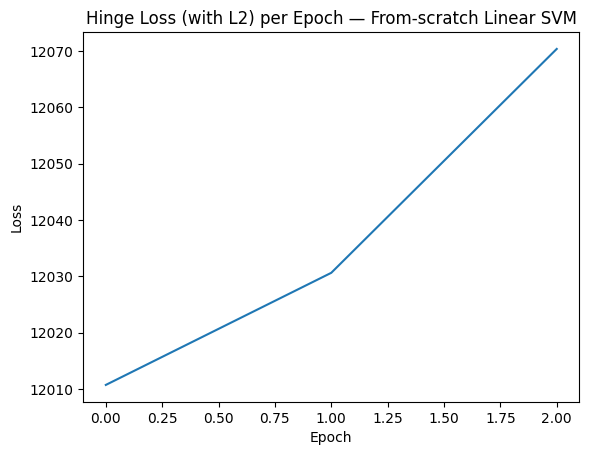

In [9]:
svm = LinearSVMScratch(C=1.0, lr=lr_val, n_epochs=10, lr_decay=0.02, early_stopping=True, es_patience=2, random_state=7)
svm.fit(Xtr, y_train)

y_pred = svm.predict(Xte)
print("From-scratch Linear SVM — IMDB (SVD-200)")
print("Test accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['neg','pos'], digits=3))

# Plot training loss
plt.figure()
plt.plot(svm.loss_curve_)
plt.title("Hinge Loss (with L2) per Epoch — From-scratch Linear SVM")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [10]:
from sklearn import svm
from sklearn.metrics import accuracy_score


# ------------------------------------------------
# TODO We will be utilizing the LinearSVC from sklearn, we will use a C=1, max_iter=2000, dual=True and random_state=7 (Exercise 5)
# First we will train on our data Xtr
# After we want to do predictions on the test data
# ------------------------------------------------
lin = svm.LinearSVC(C=1, max_iter=2000, dual=True, random_state=7)
lin.fit(Xtr, y_train)
pred_lin = lin.predict(Xte)
# ----------------------------
# Implementation Ends Here
# ----------------------------

print("LinearSVC — test accuracy:", accuracy_score(y_test, pred_lin))

LinearSVC — test accuracy: 0.8628


c:\Users\choyo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## 🧠 Mathematical Foundations of the Polynomial Kernel SVM

### 1. Problem Setup

We are given training data  
$
\{(\mathbf{x}_i, y_i)\}_{i=1}^n, \quad \mathbf{x}_i \in \mathbb{R}^d, \; y_i \in \{-1, +1\}.
$

The goal of a Support Vector Machine (SVM) is to find a decision function  
**Decision Function**: $
f(\mathbf{x}) = \sum_{j=1}^n \beta_j K(\mathbf{x}_j, \mathbf{x}) + b
$

that separates the two classes with the largest possible margin.

---

### 2. The Polynomial Kernel

Instead of using raw dot products, we map data into a higher-dimensional space via the **polynomial kernel**:
$
K(\mathbf{x}, \mathbf{z}) = (G\, \mathbf{x}^\top \mathbf{z} + c_0)^{d},
$
where:

- $( G > 0 )$ controls how strongly similarity depends on the dot product  
- $( c_0 )$ (often called `coef0` in code) shifts the kernel to include lower-order terms  
- $( d )$ is the **degree** of the polynomial and controls nonlinearity

This kernel implicitly represents all polynomial interactions between features up to degree $(d)$.

---

### 3. Regularized Risk (Squared Hinge Form)

We minimize the **regularized empirical risk** in the Reproducing Kernel Hilbert Space (RKHS):

$
J(\boldsymbol{\beta}, b) = \frac{\lambda}{2}\,\boldsymbol{\beta}^\top K \boldsymbol{\beta} + \frac{1}{n}\sum_{i=1}^n \max(0,\, 1 - y_i f_i)^2, \text{where} \quad f_i = (K\boldsymbol{\beta})_i + b \quad \text{and} \quad K_{ij} = K(\mathbf{x}_i, \mathbf{x}_j). $

- The first term $( \frac{\lambda}{2}\boldsymbol{\beta}^\top K \boldsymbol{\beta} )$ is a **regularizer** that penalizes model complexity.  
- The second term is the **squared hinge loss**, which penalizes samples that violate the margin constraint $( y_i f_i \ge 1 )$.

---

### 4. Gradient Derivations

Let $( r_i = \max(0, 1 - y_i f_i) )$.  
Only samples with $( y_i f_i < 1 )$ contribute to the gradient.

**Gradients:**

$ \nabla_{\boldsymbol{\beta}} J = \lambda K \boldsymbol{\beta} - \frac{2}{n}\, K(\mathbf{y} \odot \mathbf{r}), \nabla_b J = -\frac{2}{n}\sum_{i=1}^n y_i r_i.
$

Here $( \odot )$ denotes element-wise multiplication.

These are the update directions used by the optimizer in the implementation.

---

### 5. Optimization via Gradient Descent

We update parameters using gradient-based optimization (Adam in the code):

$
\boldsymbol{\beta} \leftarrow \boldsymbol{\beta} - \eta\, \nabla_{\boldsymbol{\beta}} J,
\quad
b \leftarrow b - \eta\, \nabla_b J.
$

Adam adaptively rescales these gradients using running estimates of their first and second moments.

---

### 6. Decision Function After Training

The learned decision function becomes:

$
f(\mathbf{x}) = \sum_{j=1}^n \beta_j K(\mathbf{x}_j, \mathbf{x}) + b,
$
and the prediction rule is:
$
\hat{y} = \operatorname{sign}(f(\mathbf{x})).
$

---

### 7. Interpretation

| Symbol | Meaning | Notes |
|:-------|:---------|:------|
| $(K(\mathbf{x}, \mathbf{z})$) | Polynomial kernel | Expands dot products to polynomial feature space |
| $(\boldsymbol{\beta}$) | Coefficients of the kernel expansion | Similar to dual variables \( \alpha \) in classic SVM |
| $(b$) | Bias/intercept | Shifts the decision boundary |
| $(\lambda$) | Regularization strength | Controls smoothness of boundary |
| $(r_i$) | Margin violation residual | Non-zero if $( y_i f_i < 1 $) |

The polynomial kernel allows the SVM to form **curved, nonlinear decision boundaries**.  
Higher degrees \(d\) increase flexibility, but also the risk of overfitting.

---

### 8. Summary of the Objective

The optimization performed in code minimizes:
$ \boxed{ \min_{\boldsymbol{\beta}, b} \left[ \frac{\lambda}{2}\boldsymbol{\beta}^\top K\boldsymbol{\beta} + \frac{1}{n}\sum_{i=1}^n \max(0, 1 - y_i((K\boldsymbol{\beta})_i + b))^2 \right] }
$

This is a smooth, differentiable version of the kernel SVM objective that can be solved by gradient descent without SMO or quadratic programming.

---


Dataset=moons, degree=3, gamma=1.0, coef0=1.0
Custom-GD:  lam=0.01  epochs=2000  lr=0.05  time=0.233s  train_acc=0.933  test_acc=0.928
sklearn SVC: C≈0.2381 time=0.002s  train_acc=0.919  test_acc=0.922


c:\Users\choyo\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\colors.py:2294: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
c:\Users\choyo\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\colors.py:2295: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)
c:\Users\choyo\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\colors.py:2294: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
c:\Users\choyo\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\colors.py:2295: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)
c:\Users\choyo\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\colors.py:2294: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
c:\Users\choyo\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\colors.py:2295: RuntimeWarning: invalid value e

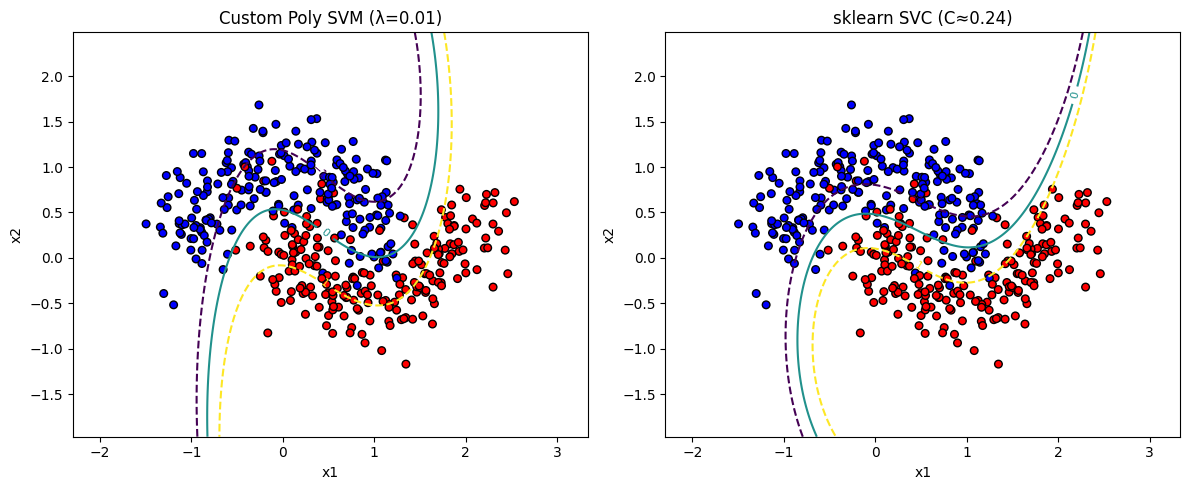

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.svm import SVC
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split

# ------------------- Your gradient-based poly SVM (no SMO) ------------------- #
class PolyKernelSVM_GD:
    """
    Kernel SVM via gradient descent (squared hinge in a kernelized primal).
    J(β, b) = (λ/2) * β^T K β + (1/n) * Σ_i max(0, 1 - y_i * (Kβ + b)_i)^2
    Decision: f(x) = Σ_j β_j K(x_j, x) + b
    Labels in {-1, +1}.
    """
    def __init__(self, degree=3, gamma=None, coef0=1.0, lam=1e-2,
                 lr=5e-2, epochs=2000, adam_beta1=0.9, adam_beta2=0.999, adam_eps=1e-8,
                 random_state=0, verbose=False):
        self.degree = int(degree)
        self.gamma = (1.0) if gamma is None else float(gamma)
        self.coef0 = float(coef0)
        self.lam = float(lam)
        self.lr = float(lr)
        self.epochs = int(epochs)
        self.beta1 = float(adam_beta1)
        self.beta2 = float(adam_beta2)
        self.adam_eps = float(adam_eps)
        self.rs = np.random.RandomState(random_state)
        self.verbose = verbose
        self.X = None; self.beta = None; self.b = 0.0; self.K = None

    def _poly_kernel(self, X, Z):
        X = np.asarray(X, dtype=float); Z = np.asarray(Z, dtype=float)
        g = self.gamma if self.gamma is not None else 1.0 / X.shape[1]
        # ------------------------------------------------
        # TODO Refer to the Polynomial Kernel section in the cell above (Exercise 6)
        # ------------------------------------------------
        return (g * (X @ Z.T) + self.coef0) ** self.degree
        # ----------------------------
        # Implementation Ends Here
        # ----------------------------

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = (np.asarray(y, dtype=float))
        assert set(np.unique(y)).issubset({-1.0, 1.0}), "Labels must be {-1,+1}"
        n = X.shape[0]
        self.X = X
        # ------------------------------------------------
        # TODO Refer to the Polynomial Kernel section in the cell above (Exercise 7)
        # Hint we might use X twice (since we are building the training kernel matrix between every pair of training samples)
        # ------------------------------------------------
        self.K = self._poly_kernel(X, X)
        # ----------------------------
        # Implementation Ends Here
        # ----------------------------
        self.beta = np.zeros(n); self.b = 0.0

        m_beta = np.zeros_like(self.beta); v_beta = np.zeros_like(self.beta)
        m_b = 0.0; v_b = 0.0

        for t in range(1, self.epochs + 1):
            # ------------------------------------------------
            #TODO Refer to the decision function defined in the 1) Problem Setup in the cell above (Exercise 8)
            # ------------------------------------------------
            f = self.K @ self.beta + self.b
            # ----------------------------
            # Implementation Ends Here
            # ----------------------------
            margin = y * f
            r = np.clip(1.0 - margin, 0.0, None)

            grad_beta = self.lam * (self.K @ self.beta) - (2.0 / n) * (self.K @ (y * r))
            grad_b = -(2.0 / n) * np.sum(y * r)

            m_beta = self.beta1*m_beta + (1-self.beta1)*grad_beta
            v_beta = self.beta2*v_beta + (1-self.beta2)*(grad_beta**2)
            m_b = self.beta1*m_b + (1-self.beta1)*grad_b
            v_b = self.beta2*v_b + (1-self.beta2)*(grad_b**2)

            m_beta_hat = m_beta / (1 - self.beta1**t)
            v_beta_hat = v_beta / (1 - self.beta2**t)
            m_b_hat = m_b / (1 - self.beta1**t)
            v_b_hat = v_b / (1 - self.beta2**t)

            self.beta -= self.lr * m_beta_hat / (np.sqrt(v_beta_hat) + self.adam_eps)
            self.b    -= self.lr * m_b_hat / (np.sqrt(v_b_hat) + self.adam_eps)

            if self.verbose and (t % max(1, self.epochs // 10) == 0 or t == 1):
                reg = 0.5 * self.lam * (self.beta @ (self.K @ self.beta))
                loss = (r ** 2).mean()
                print(f"[{t:5d}/{self.epochs}] loss={loss:.4f} reg={reg:.4f} obj={loss+reg:.4f}")
        return self

    def decision_function(self, Xq):
        Kq = self._poly_kernel(np.asarray(Xq, dtype=float), self.X)
        # ------------------------------------------------
        #TODO Refer to the decision function after training section defined in the cell above (Exercise 9)
        # ------------------------------------------------
        return Kq @ self.beta + self.b
        # ----------------------------
        # Implementation Ends Here
        # ----------------------------

    def predict(self, Xq):
        return np.where(self.decision_function(Xq) >= 0.0, 1.0, -1.0)

# ------------------- Helpers ------------------- #
def plot_side_by_side(models, titles, X, y):
    x_min, x_max = X[:,0].min()-0.8, X[:,0].max()+0.8
    y_min, y_max = X[:,1].min()-0.8, X[:,1].max()+0.8
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                         np.linspace(y_min, y_max, 400))
    grid = np.c_[xx.ravel(), yy.ravel()]
    fig, axes = plt.subplots(1, len(models), figsize=(6*len(models), 5))
    if len(models) == 1: axes = [axes]
    for ax, model, title in zip(axes, models, titles):
        zz = model.decision_function(grid).reshape(xx.shape)
        ax.contourf(xx, yy, np.sign(zz), levels=[-np.inf,0,np.inf], alpha=0.2)
        cs = ax.contour(xx, yy, zz, levels=[-1,0,1], linestyles=['--','-','--'])
        ax.clabel(cs, inline=True, fontsize=8)
        ax.scatter(X[:,0], X[:,1], c=(y>0).astype(int), cmap='bwr', edgecolor='k', s=30)
        ax.set_title(title); ax.set_xlabel("x1"); ax.set_ylabel("x2")
    plt.tight_layout(); plt.show()

# ------------------- Config ------------------- #
DATASET = "moons"      # "moons" or "circles"
NOISE = 0.25
N_SAMPLES = 600
TEST_SIZE = 0.3
RS = 42

DEGREE = 3
GAMMA = 1.0
COEF0 = 1.0

# λ ↔ C rough mapping:
# For squared hinge with averaging over n, a common heuristic is C ≈ 1/(λ n).
# You can tweak around this to match margins more closely.
def lambda_to_C(lam, n): return 1.0 / (lam * n)

LAM = 1e-2
EPOCHS = 2000
LR = 5e-2

# ------------------- Data ------------------- #
if DATASET == "moons":
    X, y01 = make_moons(n_samples=N_SAMPLES, noise=NOISE, random_state=RS)
elif DATASET == "circles":
    X, y01 = make_circles(n_samples=N_SAMPLES, noise=NOISE, factor=0.5, random_state=RS)
else:
    raise ValueError("DATASET must be 'moons' or 'circles'.")

y = 2*y01 - 1  # {0,1} -> {-1,+1}
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=TEST_SIZE, random_state=RS, stratify=y01)
y01_tr, y01_te = train_test_split(y01, test_size=TEST_SIZE, random_state=RS, stratify=y01)

# ------------------- Train: custom ------------------- #
t0 = time()
custom = PolyKernelSVM_GD(
    degree=DEGREE, gamma=GAMMA, coef0=COEF0,
    lam=LAM, lr=LR, epochs=EPOCHS, verbose=False, random_state=RS
).fit(X_tr, y_tr)
t_custom = time() - t0

# ------------------- Train: sklearn ------------------- #
C = lambda_to_C(LAM, n=X_tr.shape[0])
t1 = time()

# ------------------------------------------------
# TODO We will be utilizing the SVC from sklearn (sklearn.svm.SVC), we will use a kernel="poly", degree=DEGREE, gamma=GAMMA, coef0=COEF0, C=C (Exercise 10)
# We will train on the X_tr data and y_tr, remember sklearn expects y_tr to be {0,1}
# ------------------------------------------------
sk = SVC(kernel="poly", degree=DEGREE, gamma=GAMMA, coef0=COEF0, C=C)
sk.fit(X_tr, y01_tr)  # sklearn expects {0,1}
# ----------------------------
# Implementation Ends Here
# ----------------------------
t_sk = time() - t1

# ------------------- Evaluate ------------------- #
def acc(model, X, y):
    yp = model.predict(X)
    # unify label spaces
    if yp.min() >= 0:  # sklearn: {0,1}
        yp = np.where(yp==1, 1, -1)
    return (yp == y).mean()

train_acc_custom = acc(custom, X_tr, y_tr)
test_acc_custom  = acc(custom, X_te, y_te)

train_acc_sk = acc(sk, X_tr, y_tr)
test_acc_sk  = acc(sk, X_te, y_te)

print(f"Dataset={DATASET}, degree={DEGREE}, gamma={GAMMA}, coef0={COEF0}")
print(f"Custom-GD:  lam={LAM}  epochs={EPOCHS}  lr={LR}  time={t_custom:.3f}s  "
      f"train_acc={train_acc_custom:.3f}  test_acc={test_acc_custom:.3f}")
print(f"sklearn SVC: C≈{C:.4f} time={t_sk:.3f}s  "
      f"train_acc={train_acc_sk:.3f}  test_acc={test_acc_sk:.3f}")

# ------------------- Plot side-by-side ------------------- #
# Wrap sklearn model with a decision_function in {-1,+1} convention
class SKWrap:
    def __init__(self, svc): self.svc = svc
    def decision_function(self, Xq):
        return self.svc.decision_function(Xq)
    def predict(self, Xq):
        return np.where(self.svc.decision_function(Xq) >= 0, 1, -1)

plot_side_by_side(
    [custom, SKWrap(sk)],
    [f"Custom Poly SVM (λ={LAM})", f"sklearn SVC (C≈{C:.2g})"],
    X_tr, y_tr
)


# **Questions and Answers** (10 points)

---

### **1. Regularization Parameter**  

What role does the regularization parameter (C) play in a Linear SVM?

**Answer:**

The regularization parameter C controls the trade-off between maximizing the margin and minimizing classification errors. A larger C value places more emphasis on correctly classifying all training points (smaller margin, more complex decision boundary), potentially leading to overfitting. A smaller C allows more margin violations, creating a wider margin and simpler decision boundary that generalizes better. In the objective function, C scales the hinge loss penalty: higher C means misclassifications are penalized more heavily.

---

### **2. Linear SVM's**

Why are Linear SVMs typically preferred for high-dimensional, sparse datasets (like TF-IDF text features)?

**Answer:**

Linear SVMs are preferred for high-dimensional sparse data because:
1. **Efficiency**: They scale linearly with the number of features and samples, avoiding the computational cost of kernel computations.
2. **Linear separability**: In very high dimensions (e.g., 10,000+ TF-IDF features), data often becomes linearly separable, making complex kernels unnecessary.
3. **Sparsity handling**: Linear SVMs work directly with sparse matrices without computing dense kernel matrices, saving memory and computation.
4. **Lower overfitting risk**: With fewer parameters than kernel methods, linear SVMs are less prone to overfitting in high-dimensional spaces.
5. **Interpretability**: The learned weight vector provides insight into which features (words) are important for classification.

---

### **3. Polynomial SVM's**
How do the parameters degree (d), gamma (G), and coef0 (c₀) influence the decision boundary?

**Answer:**

- **degree (d)**: Controls the polynomial order and thus the complexity/curvature of the decision boundary. Higher degrees (e.g., d=3 vs d=2) allow more complex, curved boundaries but increase overfitting risk. d=1 reduces to a linear kernel.

- **gamma (G)**: Scales the dot product before applying the polynomial transformation. Higher gamma values make the kernel more sensitive to individual data points, creating tighter, more localized decision boundaries. Lower gamma produces smoother, more global boundaries.

- **coef0 (c₀)**: The constant term that shifts the kernel, controlling the influence of lower-order polynomial terms versus higher-order interactions. Larger coef0 gives more weight to lower-order terms (including the constant), while coef0=0 emphasizes only pure polynomial interactions. This affects boundary shape and model flexibility.

---

### **4. Overfitting Polynomial SVM**
Why might a Polynomial SVM overfit more easily than a Linear SVM?

**Answer:**

Polynomial SVMs overfit more easily because:
1. **Higher model complexity**: Polynomial kernels implicitly map data to a much higher-dimensional feature space (all polynomial combinations up to degree d), giving the model more capacity to fit noise in the training data.
2. **More flexible boundaries**: Polynomial kernels create curved, nonlinear decision boundaries that can closely follow training data patterns, including noise and outliers.
3. **More hyperparameters**: With degree, gamma, and coef0 to tune, polynomial SVMs have more ways to overfit if not properly regularized.
4. **Curse of dimensionality**: The implicit feature space grows exponentially with degree, making it easier to perfectly separate training data while losing generalization ability.

Linear SVMs, with their simpler decision boundaries and lower-dimensional representation, are naturally more constrained and less prone to overfitting.

---

### **5. Polynomial Kernel Purpose**
Why does a Polynomial kernel make linear classifiers capable of separating nonlinear data?

**Answer:**

The polynomial kernel enables linear classifiers to separate nonlinear data through the **kernel trick**: it implicitly maps input features into a higher-dimensional space where nonlinear relationships in the original space become linear, without explicitly computing the transformation.

For example, K(x, z) = (x^T z + c₀)^d represents the dot product in a feature space containing all polynomial combinations (x₁², x₁x₂, x₂², etc.) up to degree d. In this expanded space, data that was nonlinearly separable (e.g., concentric circles) can become linearly separable. The SVM then finds a linear hyperplane in this high-dimensional space, which corresponds to a curved, nonlinear boundary in the original input space. This allows the model to capture complex patterns like XOR, circles, and moons without explicitly computing the expensive polynomial feature expansion.